# Deep Crossentropy method


AIMasters 2024, Алексеев Илья Алексеевич

Сурс код с моими реализациями я загрузил в гитхаб: https://github.com/voorhs/rl. 

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (0.1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (0.1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


#### grid search

Грубо перебрал гиперпараметры чтобы нащупать область оптимальных

In [1]:
percentile_list = [50, 75, 90]
n_sessions_list = [64, 128, 256]
lr_list = [0.25, 0.5, 0.75]

In [2]:
import json
from tqdm.autonotebook import tqdm
from src.tabular import experiment

logs = []
for lr in lr_list:
    for n_sessions in n_sessions_list:
        for percentile in tqdm(percentile_list):
            mean_reward, _ = experiment(
                env_name="Taxi-v3",
                n_iter=100,
                n_sessions=n_sessions,
                percentile=percentile,
                lr=lr
            )
            cur_log = dict(
                mean_reward=mean_reward,
                lr=lr,
                n_sessions=n_sessions,
                percentile=percentile
            )
            logs.append(cur_log)
json.dump(logs, open('logs.json', 'w'))

/tmp/ipykernel_18735/3557128592.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 3/3 [09:24<00:00, 188.09s/it]


In [1]:
import json

logs = json.load(open('logs.json', 'r'))
len(logs)

27

In [4]:
import pandas as pd

df = pd.DataFrame.from_records(logs)
df.head(10)

,mean_reward,lr,n_sessions,percentile
0,-391.375000,0.25,64,50
1,-1124.812500,0.25,64,75
2,-1242.437500,0.25,64,90
3,-225.875000,0.25,128,50
4,-1295.375000,0.25,128,75
5,-3065.562500,0.25,128,90
6,-151.515625,0.25,256,50
7,-407.750000,0.25,256,75
8,-2822.906250,0.25,256,90
9,-548.937500,0.50,64,50


<Axes: xlabel='n_sessions', ylabel='mean_reward'>

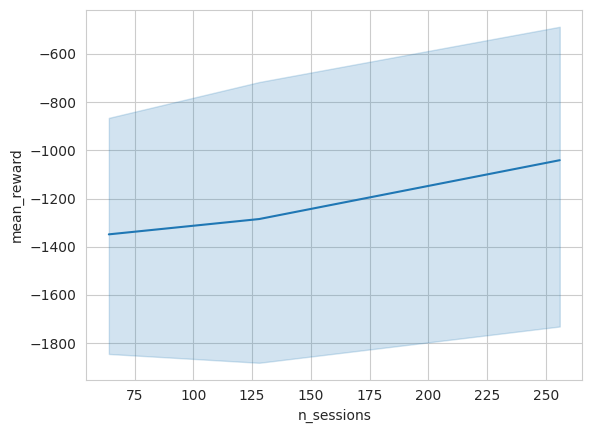

In [10]:
import seaborn as sns
sns.set_style('whitegrid')

sns.lineplot(data=df, x='n_sessions', y='mean_reward')

Вывод: нужно играть побольше сессий на одном шаге оптимизации, даже если это будет бить по времени (мы тут бьем бейзлайны by any means!)

<Axes: xlabel='percentile', ylabel='mean_reward'>

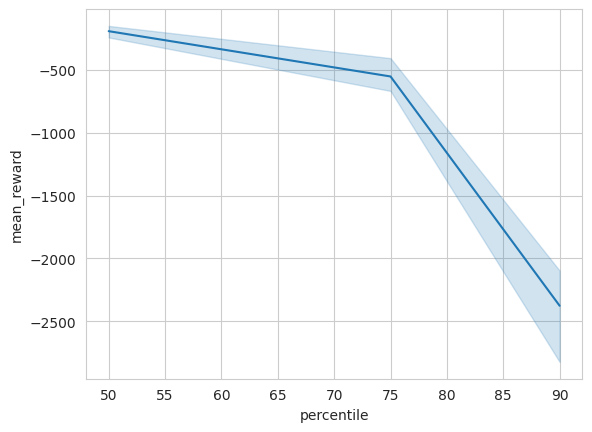

In [11]:
mask = df.n_sessions == 256
sns.lineplot(data=df[mask], x='percentile', y='mean_reward')
# df[mask].head()

Вывод: для данной задачи можно брать больше элитных сессий (== понижать percentile)

<Axes: xlabel='lr', ylabel='mean_reward'>

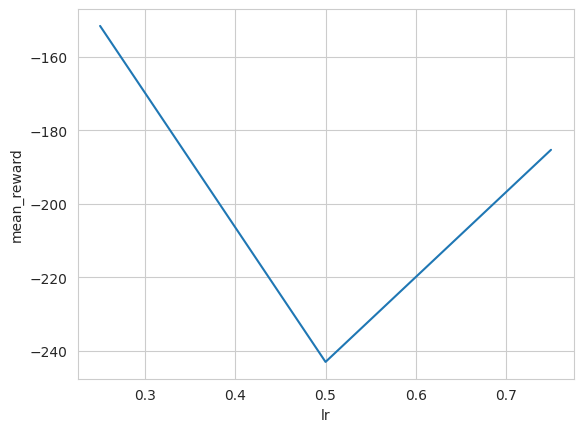

In [14]:
mask = (df.n_sessions == 256) & (df.percentile == 50)
sns.lineplot(data=df[mask], x='lr', y='mean_reward')

Вывод: тут сложно сделать какой-то вывод, но я впредь буду брать lr поменьше, это будет соответствовать более плавному обновлению таблицы политик

#### Моё решение 

In [9]:
percentile = 30
n_sessions = 1024
lr = 0.05

mean reward = 0.066, threshold=0.000


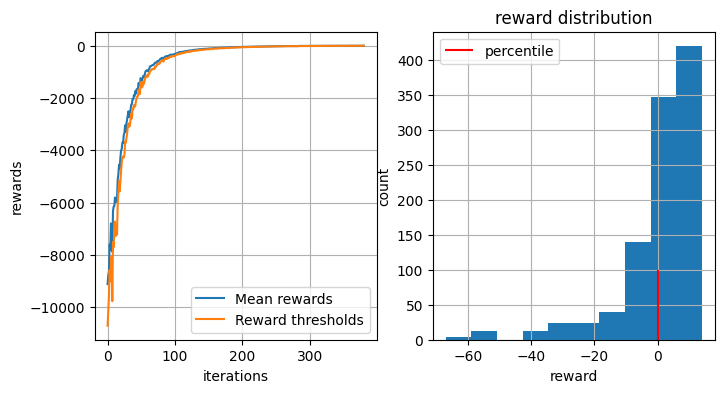

'success'

In [10]:
from src.tabular import experiment


experiment(
    env_name="Taxi-v3",
    n_iter=1000,
    n_sessions=n_sessions,
    percentile=percentile,
    lr=lr,
    mean_reward_to_win=0
)

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (0.3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.

   
* __2.2__ (up to 0.5 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (0.1 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (0.2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (0.2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.

#### Моё решение 

- сразу побил бейзлайн -100
- генерация сессий с помощью `joblib.Parallel`
- на каждом шаге метода агент обучается на `n_batches_reuse` последних батчах элитных сессий
- первые шесть шагов размер сессии 16 (чтобы ускорить начало обучения), затем размер 128 (можно погенерить больше сессий потому что агент плюс-минус обучен и не тратит много времени на эпизод) 

mean reward = -99.484, threshold=-102.000


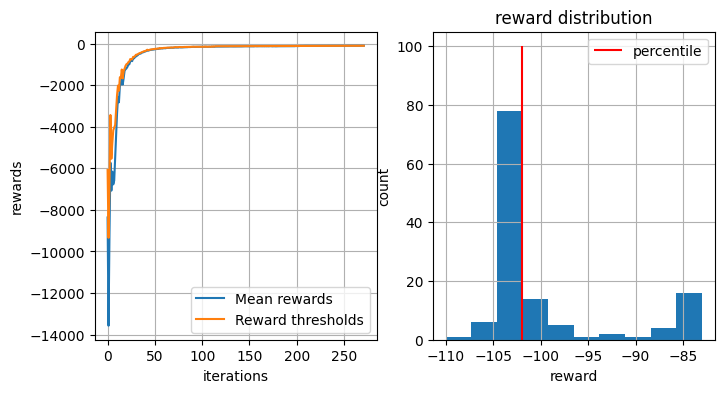

'success'

In [2]:
from sklearn.neural_network import MLPClassifier
from src.deep import experiment

experiment(
    env_name="MountainCar-v0",
    network=MLPClassifier(
        hidden_layer_sizes=(128, 128, 128),
        activation="tanh",
    ),
    n_iter=1000,
    n_sessions=[16,16,16,16,16,16,128],
    percentile=60,
    mean_reward_to_win=-100,
    mp=True,
    t_max=int(5e4),
    n_batches_reuse=5,
    # topk=3
)

### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

### Bonus tasks

* __2.3 bonus__ (0.2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (0.3 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 0.4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

#### Моё решение 
Просто применил все те же параметры, что и для дискретного случая. Обучилось даже быстрее.

mean reward = 90.228, threshold=90.982


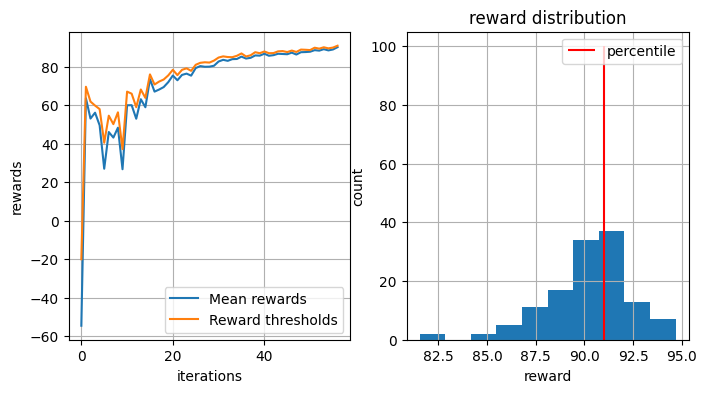

'success'

In [1]:
from sklearn.neural_network import MLPRegressor
from src.deep import experiment

experiment(
    env_name="MountainCarContinuous-v0",
    network=MLPRegressor(
        hidden_layer_sizes=(128, 128, 128),
        activation="tanh",
    ),
    n_iter=1000,
    n_sessions=[16,16,16,16,16,16,128],
    percentile=60,
    mean_reward_to_win=90,
    mp=True,
    t_max=int(5e4),
    n_batches_reuse=5,
    noise=False,
    sigma=.3
)